<a href="https://colab.research.google.com/github/giuseppesalvi/MLinA-DL-Uncertainty/blob/main/MLinA_DL_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

ROOTDIR_DATA = "/content/drive/MyDrive/Datasets/Teaching_dataset/"
TRAIN_ENSAMBLE = False

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Assignment #1**: making new Layers and Models via subclassing
Building a ResNet18 architecture leveraging tf.keras.Model subclassing



### ResNet block: the residual layer

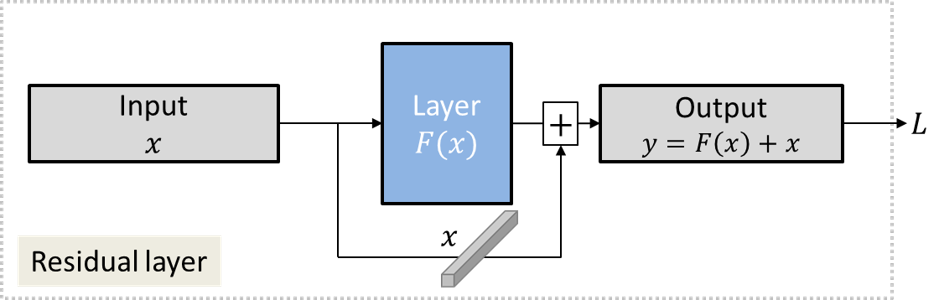

Notes:
*   **Batch normalization** is implemented right after each convolution and before activation
*   If the **input dimension has the same dimension as the output** the block implements an identity function 
*   **Otherwise** in the skip connection we insert a 1x1 convolutional block

In [3]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            num_channels, 
            padding='same', 
            kernel_size=3, 
            strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(
            num_channels, 
            kernel_size=3, 
            padding='same')
        self.conv_1x1 = None
        if use_1x1conv:
            self.conv_1x1 = tf.keras.layers.Conv2D(
                num_channels, 
                kernel_size=1, 
                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):

        # Y = F(X) + X

        # first layer
        Y = self.conv1(X)
        Y = self.bn1(Y)
        Y = tf.keras.activations.relu(Y)
        
        # second layer
        Y = self.conv2(Y)
        Y = self.bn2(Y)

        # if input has the same dimension as the output the block implements an
        # identity function, otherwise we insert a 1x1 convolutional block
        if self.conv_1x1 is not None:
            X = self.conv_1x1(X)

        # Add Residual
        Y += X 
        return tf.keras.activations.relu(Y)

        

In [4]:
class ResnetBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, num_residuals, downscale=True,
                 **kwargs):
        super(ResnetBlock, self).__init__(**kwargs)
        self.residual_layers = []
        for i in range(num_residuals):
            if i == 0 and downscale:
                self.residual_layers.append(
                    Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual(num_channels))

    def call(self, X):
        for layer in self.residual_layers.layers:
            X = layer(X)
        return X

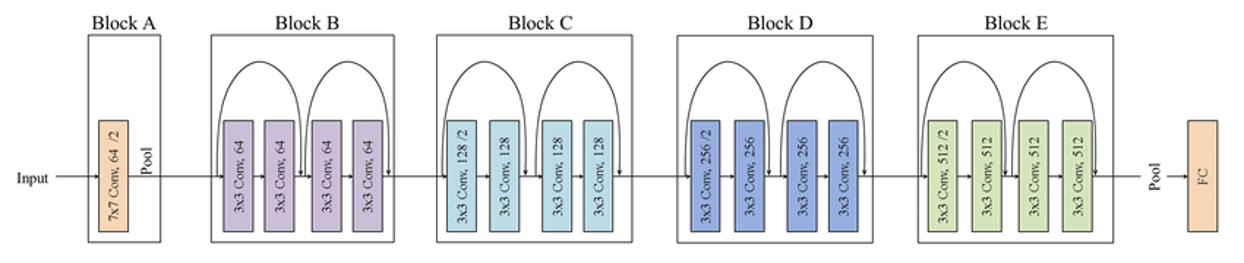

## ResNet18

In [5]:
class ResNet(tf.keras.Model):

    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(
            num_classes, 
            activation="softmax")

    def call(self, inputs):
        x = self.block_a(inputs)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.global_pool(x)
        return self.classifier(x)

# Dataset

The `tf.data` API allows you to construct, manage and reuse efficient and complex input pipelines.

Specifically, the `tf.data.Dataset` abstraction represents a sequence of elements, in which *each element is made up of one or more components*. For instance, in an image processing pipeline, an element is a single training example, consisting in a pair of tensor components: the image and its label.

The typical pattern for `tf.data.Dataset` usage is the following:

    Create a source dataset from your input data (from data stored in memory).
    Apply dataset transformations to preprocess the data.
    Iterate over the dataset and process the elements.

Read carefully the official [tf.data guide](https://www.tensorflow.org/guide/data). 

## TensorFlow Datasets (TFDS)

TFDS is a high level wrapper around `tf.data` which provides a collection of ready-to-use datasets.

In [6]:
(mnist_train, mnist_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


`tf.data.Dataset` objects can be converted to `pandas.DataFrame` with tfds.as_dataframe to be visualized on Colab.

In [8]:
tfds.as_dataframe(mnist_train.take(4), ds_info)

,image,label
0,,4
1,,1
2,,0
3,,7


`tfds.show_examples` returns a matplotlib.figure

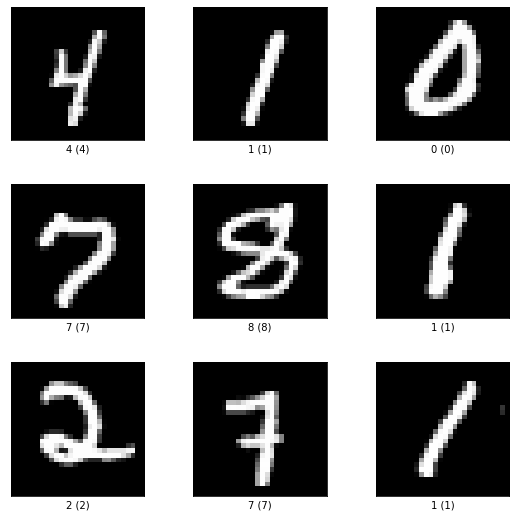

In [9]:
fig = tfds.show_examples(mnist_train, ds_info)

## Map method

In [10]:
def process_data(image, label):
    return tf.cast(image, tf.float32) / 255., tf.one_hot(label, 10, name='label', axis=-1)

mnist_train = mnist_train.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_train = mnist_train.cache()
mnist_train = mnist_train.shuffle(ds_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(128)
mnist_train = mnist_train.prefetch(tf.data.AUTOTUNE)

N.B. Do not shuffle test dataset

In [11]:
mnist_test = mnist_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
mnist_test = mnist_test.cache()
mnist_test = mnist_test.batch(128)
mnist_test = mnist_test.prefetch(tf.data.AUTOTUNE)

## **Assignment #2** Train and test on MNIST

In [12]:
net = ResNet()
net.build((1, 28, 28, 1))
net.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net.fit(mnist_train, epochs=3)
print("Accuracy on test set: {:.2f}".format(net.evaluate(mnist_test)[1]))
preds_mnist = net.predict(mnist_test)

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 7, 7, 64)             3456      
                                                                 
 resnet_block (ResnetBlock)  multiple                  148736    
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 526976    
 )                                                               
                                                                 
 resnet_block_2 (ResnetBlock  multiple                 2102528   
 )                                                               
                                                                 
 resnet_block_3 (ResnetBlock  multiple                 8399360   
 )                                                               
                                                           

# Uncertainty in DL - MC Dropout

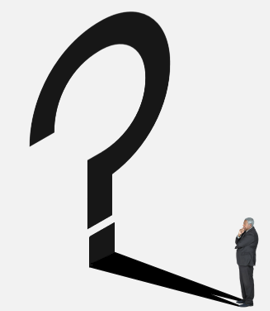

## **Assignment #3**: Code a MC Dropout-based version of ResNet18

In [23]:
from re import I
class ResNetMC(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(ResNetMC, self).__init__()
        self.mc_dropout = mc_dropout
        self.block_a = tf.keras.Sequential(
            [tf.keras.layers.Conv2D(64, 
                                    kernel_size=7, 
                                    strides=2, 
                                    padding='same'),
             tf.keras.layers.BatchNormalization(),
             tf.keras.layers.MaxPool2D(pool_size=3, 
                                       strides=2, 
                                       padding='same')])             
        self.block_b = ResnetBlock(64, 2, downscale=False)
        self.block_c = ResnetBlock(128, 2)
        self.block_d = ResnetBlock(256, 2)
        self.block_e = ResnetBlock(512, 2)
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        if self.mc_dropout:
          print("MC Dropout is active")
          
        # Insert Dropout after each layer
        x = self.block_a(inputs)
        if self.mc_dropout:
            # training set to true to use dropout during test 
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_b(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_c(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_d(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.block_e(x)
        if self.mc_dropout:
            x = tf.keras.layers.Dropout(self.mc_dropout)(x, training=True)
        x = self.global_pool(x)
        return self.classifier(x) 

## Load EMNIST

In [54]:
def show_images_from_npy(array, cmap=None):
    fig, ax = plt.subplots(1, 5)
    ax = ax.ravel()
    j = 0
    for idx in np.random.randint(0, array.shape[0], 5):
        ax[j].imshow(array[idx], cmap=cmap)
        ax[j].axis('off')
        j += 1
emnist = np.load(os.path.join(ROOTDIR_DATA, "emnist_images.npy"))
emnist_numpy = (emnist / 255).astype(np.float32)

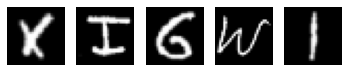

In [59]:
show_images_from_npy(emnist_numpy, cmap="gray")

N.B. Do not shuffle emnist

In [60]:
emnist = tf.data.Dataset.from_tensor_slices((np.expand_dims(emnist_numpy, axis=-1), np.zeros((len(emnist_numpy)))))
emnist = emnist.cache()
emnist = emnist.batch(128)
emnist = emnist.prefetch(tf.data.AUTOTUNE)
preds_emnist = net.predict(emnist)

## **Assignment #4**: Code a wrapper for a MC-based network
By subclassing tf.keras.Model implement a class featuring:
1.   Method to reierate predictions
2.   Method to average predictions
3.   Several metrics to compute uncertainty
4.   Method to normalize the uncertainty metric

In [61]:
class UncertaintyWrapper(tf.keras.Model):

    def __init__(self, num_classes=10, mc_dropout=None):
        super(UncertaintyWrapper, self).__init__()
        print(f"MC Dropout is set to {mc_dropout}")
        self.model = ResNetMC(mc_dropout=mc_dropout)
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(metric, multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
        # normalize the output throught 0 and 1
        return (values - values.min()) / (values.max() - values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        # make n=draws predictions, and return the result in a np array
        return np.array([self.predict(inputs) for _ in range(draws)])

    def _average_prediction(self, multiple_preds):
        # to compute the average prediction, calculate the mean on the first 
        # columnt (axis=0), so on the same sample over different predictions 
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
          return multiple_preds

    def _variance(self, multiple_preds):
        # note: if the output of the network is sure, the variance will be higher
        # for example the softmax for class a is always high and for class c and
        # b is always low
        avg_preds = self._average_prediction(multiple_preds)
        return np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def _entropy(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        eps = 1e-5
        return -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)

## **Assignment #5** Train and test such model

In [62]:
net_unc = UncertaintyWrapper(mc_dropout=0.1)
net_unc.build((1, 28, 28, 1))
net_unc.summary()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
net_unc.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics="accuracy")
net_unc.fit(mnist_train, epochs=1)
print("Accuracy on test set: {:.2f}".format(net_unc.evaluate(mnist_test)[1]))

MC Dropout is set to 0.1
MC dropout is active
Model: "uncertainty_wrapper_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res_net_mc_11 (ResNetMC)    multiple                  11186186  
                                                                 
Total params: 11,186,186
Trainable params: 11,178,378
Non-trainable params: 7,808
_________________________________________________________________
MC dropout is active
MC dropout is active
469/469 [==============================] - 38s 74ms/step - loss: 0.2761 - accuracy: 0.9127
MC dropout is active
79/79 [==============================] - 2s 20ms/step - loss: 0.2604 - accuracy: 0.9167
Accuracy on test set: 0.92


## Compute MC predicitons and compare with *deterministic* uncertainty computation

In [63]:
multiple_preds_emnist = net_unc.predict_many_times(emnist, draws=10)
multiple_preds_mnist = net_unc.predict_many_times(mnist_test, draws=10)

MC dropout is active
MC dropout is active


In [64]:
uncertainties = dict()
uncertainties_deterministic = dict()
uncertainties['mnist'] = net_unc.uncertainty_metrics(multiple_preds_mnist)
uncertainties['emnist'] = net_unc.uncertainty_metrics(multiple_preds_emnist)
uncertainties_deterministic['mnist'] = net_unc.uncertainty_metrics(preds_mnist)
uncertainties_deterministic['emnist'] = net_unc.uncertainty_metrics(preds_emnist)

Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response
Done entropy
Done variance
Done max_softmax_response


## **Assignment #6** Uncertainty metrics distributions for MNIST and EMNIST
Plot distributions in form of histograms for the different uncertainty metrics and for the different dataset (i.e., MNIST and EMNIST)


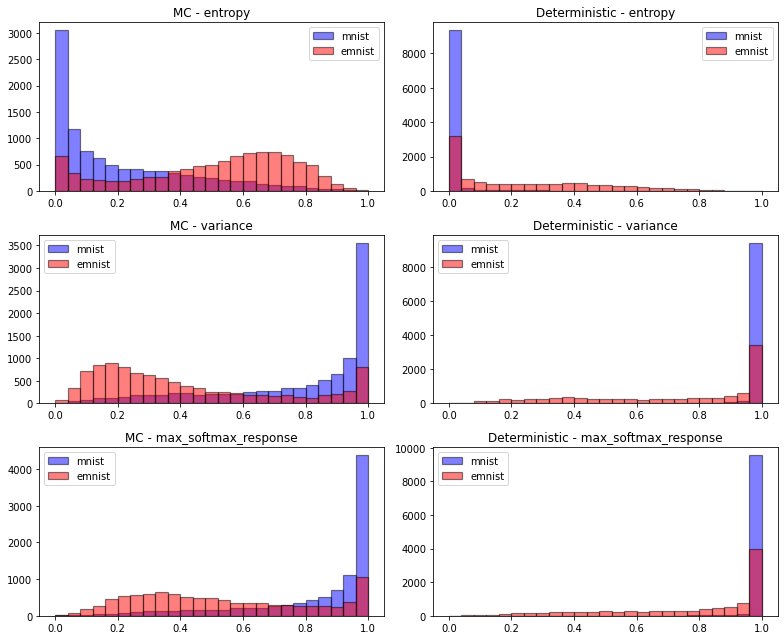

In [65]:
fig, axes = plt.subplots(len(net_unc._uncertainty_metrics.keys()), 2, figsize=(11, 9))
for ax, measure in zip(axes, net_unc._uncertainty_metrics.keys()):
    ax[0] .set_title(f"MC - {measure}")
    ax[0].hist(uncertainties['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[0].hist(uncertainties['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[0].legend()
    ax[1] .set_title(f"Deterministic - {measure}")
    ax[1].hist(uncertainties_deterministic['mnist'][measure], color="blue", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="mnist");
    ax[1].hist(uncertainties_deterministic['emnist'][measure], color="red", log=False, bins=25, edgecolor='black', linewidth=1.2, alpha=0.5, label="emnist");
    ax[1].legend()
plt.tight_layout()

## **Assignment #7** Take a look at confident and not-confident predictions for EMNIST
Filter confident and not-confident images based on uncertainty values and plot some of them

In [71]:
n_examples = 5
emnist_confident = emnist_numpy[uncertainties['emnist']['variance'] >= 0.95]
emnist_not_confident = emnist_numpy[uncertainties['emnist']['variance'] < 0.1]

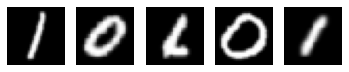

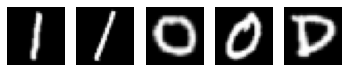

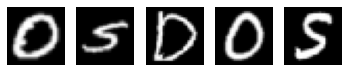

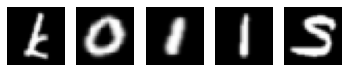

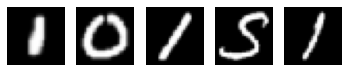

In [74]:
# plot some samples for which the moddel is confident
# we can see how it's confident for letter that are similar to numbers like I, O, S
for _ in range(n_examples):
    show_images_from_npy(emnist_confident, cmap="gray")

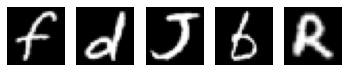

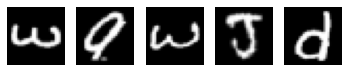

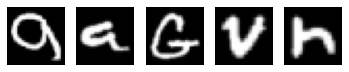

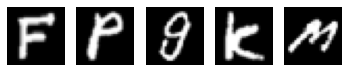

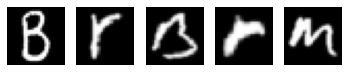

In [76]:
# Plot some samples for which the model is not confident
# We can see how the model is not confident for letters that are very articulated
# and different from numbers like m, w, q 
for _ in range(n_examples):
    show_images_from_npy(emnist_not_confident, cmap="gray")

# Uncertainty in DL - Test Time Augmentation-Based
By subclassing the previously created UncertaintyWrapper class make a class featuring a *predict_many_times* method which implements TTA with four different policies for data augmentation:
1.   Random crop
2.   Random flip
3.   Random contrast
4.   Random zoom

In [67]:
class TTAWrapper(UncertaintyWrapper):
    def __init__(self, num_classes=10):
        super(TTAWrapper, self).__init__()
        self.model = ResNet()
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics["variance"] = self._variance
        self._uncertainty_metrics["max_softmax_response"] = self._max_softmax_response

    def call(self, inputs):
        return self.model(inputs)

    def predict_many_times(self, ds, policy, repeat=1):
        pred_augmented = list()


## **Assignment #8** Train and test such model

In [68]:
net_tta = TTAWrapper()
[...]

MC Dropout is set to None


[Ellipsis]

In [69]:
emnist_preds_tta = net_tta.predict_many_times(emnist, "random_zoom", repeat=10)
mnist_preds_tta = net_tta.predict_many_times(mnist_test, "random_zoom", repeat=10)

## **Assignment #9** Uncertainty metrics distributions for MNIST and EMNIST
Plot distributions in form of histograms for the different uncertainty metrics and for the different dataset (i.e., MNIST and EMNIST)



In [70]:
[...]

[Ellipsis]